# Name: Asad Ansari 
# Assignment 4 - INF 2178

# 1. Needed Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.power import TTestIndPower
import pingouin as pg


# 2. Functions

In [2]:
# Function to determine what proportion of a column is null
def prop_is_null(data_frame):
    props_as_dict = {}
    for col in data_frame.columns:
        null_prop = round(data_frame[col].isnull().mean() * 100, 2)
        props_as_dict[col] = [str(null_prop) + "%", data_frame[col].isnull().sum()]
    return props_as_dict

# Function to convert column to number or datetime
def convert_cols(data_frame, conversion_type, lst_of_cols):
    if conversion_type.lower() == "number":
        for col in lst_of_cols:
            data_frame[col] = pd.to_numeric(data_frame[col], errors="coerce")
    if conversion_type.lower() == "datetime":
        for col in lst_of_cols:
            data_frame[col] = pd.to_datetime(data_frame[col], errors="coerce")

# Gets a list of numerical columns in a dataframe
def get_numerical_cols(data_frame, non_numerical_cols=[]):
    all_cols_lst = data_frame.columns.to_list()
    numerical_cols = []
    for col in all_cols_lst:
        if col not in non_numerical_cols:
            numerical_cols.append(col)
    return numerical_cols

def get_descriptive_stats(data_frame, all=False, lst_of_columns=[]):
    if all == True:
        # Getting descriptive statistics for all columns
        descriptive_stats = data_frame.describe(include="all")
        descriptive_stats_df = descriptive_stats.transpose()
    if all == False:
        # Getting descriptive statistics for specified columns
        descriptive_stats = data_frame[lst_of_columns].describe()
        descriptive_stats_df = descriptive_stats.transpose()
    return descriptive_stats_df

def melt_me(data_frame, variable_name, val_name, id_variables=[],
            value_variables=[]):
    melted_df = pd.melt(data_frame, id_vars=id_variables,
                        value_vars=value_variables, var_name=variable_name, value_name=val_name)
    return melted_df


# 3. EDA

In [3]:
file_name = "INF2178_A4_data.csv"
df_original = pd.read_csv(file_name)
df = df_original
df = df.drop(df.columns[0], axis=1)


In [4]:
for col in df.columns:
    upper_col = col.upper()
    if upper_col == "M/F":
        upper_col = "SEX"
    if upper_col == "SUBJECT ID":
        upper_col = "SUBJECT_ID"
    if upper_col == "MRI ID":
        upper_col = "MRI_ID"
    if upper_col == "MR DELAY":
        upper_col = "MR_DELAY"
    df.rename(columns={col:upper_col}, inplace=True)


In [5]:
df.describe()


,VISIT,MR_DELAY,AGE,EDUC,SES,MMSE,CDR,ETIV,NWBV,ASF
count,294.000000,294.000000,294.000000,294.000000,279.000000,293.000000,294.000000,294.000000,294.000000,294.000000
mean,1.489796,349.785714,76.411565,14.561224,2.491039,27.259386,0.301020,1478.853741,0.731381,1.203109
std,0.500748,400.741520,7.607074,2.884818,1.128008,3.413454,0.381347,176.559755,0.037373,0.139365
min,1.000000,0.000000,60.000000,6.000000,1.000000,15.000000,0.000000,1106.000000,0.646000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,26.000000,0.000000,1347.250000,0.703000,1.118250
50%,1.000000,0.000000,76.000000,14.500000,2.000000,29.000000,0.000000,1461.500000,0.732000,1.201000
75%,2.000000,671.500000,81.000000,16.000000,3.000000,30.000000,0.500000,1569.000000,0.756000,1.302750
max,2.000000,1707.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [6]:
num_rows = df.shape[0]
num_columns = df.shape[1]

num_rows_cols_info_df = pd.DataFrame({
    "Description": ["Number of Rows", "Number of Columns"],
    "Value": [num_rows, num_columns]})

num_rows_cols_info_df


,Description,Value
0,Number of Rows,294
1,Number of Columns,15


In [7]:
# Display what proportion of entries are null
null_cols = prop_is_null(df)
display(null_cols)


{'SUBJECT_ID': ['0.0%', 0],
 'MRI_ID': ['0.0%', 0],
 'GROUP': ['0.0%', 0],
 'VISIT': ['0.0%', 0],
 'MR_DELAY': ['0.0%', 0],
 'SEX': ['0.0%', 0],
 'HAND': ['0.0%', 0],
 'AGE': ['0.0%', 0],
 'EDUC': ['0.0%', 0],
 'SES': ['5.1%', 15],
 'MMSE': ['0.34%', 1],
 'CDR': ['0.0%', 0],
 'ETIV': ['0.0%', 0],
 'NWBV': ['0.0%', 0],
 'ASF': ['0.0%', 0]}

In [8]:
# Drop blanks
cleaned_df = df.copy().dropna()


In [9]:
non_numerical_cols = ["SUBJECT_ID", "MRI_ID", "GROUP", "SEX", "HAND"]
numerical_cols = get_numerical_cols(cleaned_df, non_numerical_cols)
print(numerical_cols)


['VISIT', 'MR_DELAY', 'AGE', 'EDUC', 'SES', 'MMSE', 'CDR', 'ETIV', 'NWBV', 'ASF']


In [10]:
convert_cols(cleaned_df, "number", numerical_cols)


In [11]:
cleaned_df.head()


,SUBJECT_ID,MRI_ID,GROUP,VISIT,MR_DELAY,SEX,HAND,AGE,EDUC,SES,MMSE,CDR,ETIV,NWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
4,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
5,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200,0.718,1.462
6,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039


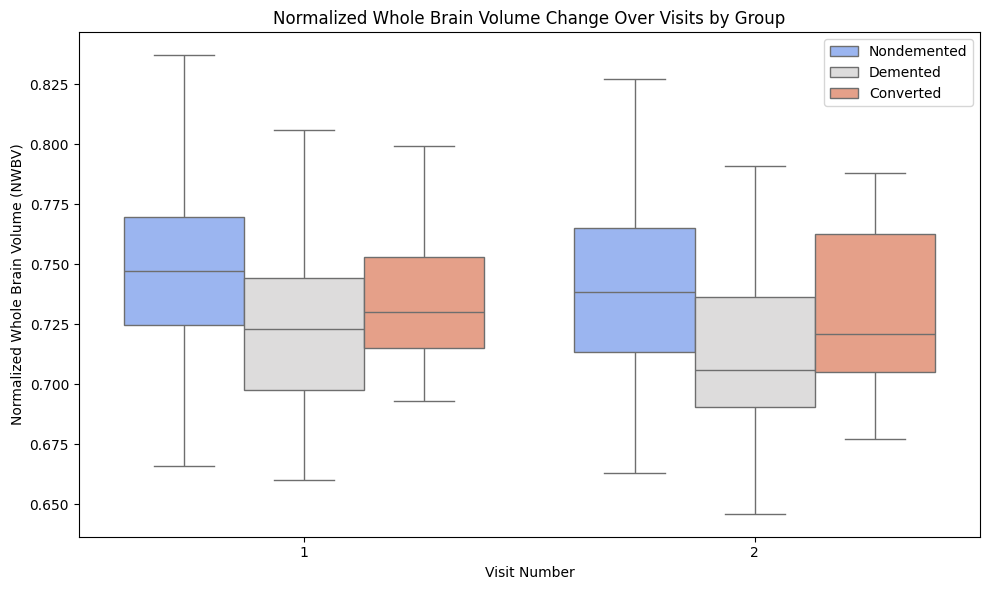

In [12]:
nwbv_df = cleaned_df[["GROUP", "VISIT", "MR_DELAY", "NWBV"]].dropna()

# Turn VISIT into categorial variable
nwbv_df["VISIT"] = nwbv_df["VISIT"].astype("category")

# Boxplot for NWBV changes over visits by group
plt.figure(figsize=(10, 6))
sns.boxplot(x="VISIT", y="NWBV", hue="GROUP", data=nwbv_df, palette="coolwarm")
plt.title("Normalized Whole Brain Volume Change Over Visits by Group")
plt.xlabel("Visit Number")
plt.ylabel("Normalized Whole Brain Volume (NWBV)")
plt.legend(title="", loc="upper right")
plt.tight_layout()
plt.show()


In [13]:
grouped_stats = cleaned_df.groupby(["GROUP", "VISIT"])["NWBV"].agg(["mean", "median", "quantile"])

grouped_stats["IQR"] = cleaned_df.groupby(["GROUP", "VISIT"])["NWBV"].quantile(0.75) - cleaned_df.groupby(["GROUP", "VISIT"])["NWBV"].quantile(0.25)

grouped_stats.reset_index()


,GROUP,VISIT,mean,median,quantile,IQR
0,Converted,1,0.737786,0.7300,0.7300,0.03775
1,Converted,2,0.728417,0.7210,0.7210,0.05775
2,Demented,1,0.723482,0.7230,0.7230,0.04650
3,Demented,2,0.712764,0.7060,0.7060,0.04600
4,Nondemented,1,0.746125,0.7470,0.7470,0.04500
5,Nondemented,2,0.737671,0.7385,0.7385,0.05150


In [14]:
cleaned_melted_df = pd.melt(cleaned_df, id_vars=["SUBJECT_ID", "GROUP", "VISIT"], value_vars=["NWBV"])


# 4. Two-way mixed-effect ANOVA

## 4.1 - ANOVA Assumption 1: Normality Test

In [15]:
# Assumption 1: Normality Test
# Group by "GROUP" & "VISIT" to check normality within each subgroup.
groups = cleaned_df["GROUP"].unique()
visits = cleaned_df["VISIT"].unique()

# Dict to store p-values for Shapiro-Wilk tests
normality_tests = {}

for group in groups:
    for visit in visits:
        # Filtering the data for each subgroup
        subgroup_data = cleaned_df[(cleaned_df["GROUP"] == group) & (cleaned_df["VISIT"] == visit)]["NWBV"]
        # Performing Shapiro-Wilk test for normality
        _, p_value = stats.shapiro(subgroup_data)
        # Storing the p-value
        normality_tests[f"{group}_Visit{visit}"] = p_value

# Display p-values for normality tests
normality_tests


{'Nondemented_Visit1': 0.771978318043403,
 'Nondemented_Visit2': 0.5108552369529133,
 'Demented_Visit1': 0.8777173909634739,
 'Demented_Visit2': 0.2948692647530252,
 'Converted_Visit1': 0.3414671116115821,
 'Converted_Visit2': 0.5023515660175943}

In [16]:
# Check Normality using pingouin just for fun!

# List to store normality results
normality_results = []

# Iterate over each combination of GROUP and VISIT
for (group, visit), group_data in cleaned_melted_df.groupby(["GROUP", "VISIT"]):
    # Run normality test for the 'value' column
    normality_test = pg.normality(group_data["value"])
    kya_normal_hay = normality_test["pval"].values[0] > 0.05
    # Append the results to normality results list created above
    normality_results.append({"GROUP": group, "VISIT": visit, "W": normality_test["W"].values[0], "p-val": normality_test['pval'].values[0], "normal": kya_normal_hay})

# Convert the list of results into a DataFrame (displays better in notebook)
normality_results_df = pd.DataFrame(normality_results)
normality_results_df


,GROUP,VISIT,W,p-val,normal
0,Converted,1,0.933507,0.341467,True
1,Converted,2,0.940329,0.502352,True
2,Demented,1,0.988695,0.877717,True
3,Demented,2,0.974644,0.294869,True
4,Nondemented,1,0.988723,0.771978,True
5,Nondemented,2,0.983956,0.510855,True


## 4.2 - ANOVA Assumption 2: Homogeneity of Variances

In [17]:
# Assumption 2: Homogeneity of Variances
# Isolate NWBV for each group at each visit for homogeneity test
# There is a better way to do this but it's the end of the semester and I am tired!

nondemented_nwbv_visit1 = cleaned_df[(cleaned_df["GROUP"] == "Nondemented") & (cleaned_df["VISIT"] == 1)]["NWBV"]
demented_nwbv_visit1 = cleaned_df[(cleaned_df["GROUP"] == "Demented") & (cleaned_df["VISIT"] == 1)]["NWBV"]
converted_nwbv_visit1 = cleaned_df[(cleaned_df["GROUP"] == "Converted") & (cleaned_df["VISIT"] == 1)]["NWBV"]

nondemented_nwbv_visit2 = cleaned_df[(cleaned_df["GROUP"] == "Nondemented") & (cleaned_df["VISIT"] == 2)]["NWBV"]
demented_nwbv_visit2 = cleaned_df[(cleaned_df["GROUP"] == "Demented") & (cleaned_df["VISIT"] == 2)]["NWBV"]
converted_nwbv_visit2 = cleaned_df[(cleaned_df["GROUP"] == "Converted") & (cleaned_df["VISIT"] == 2)]["NWBV"]

# Performing Levene's test for homogeneity of variances
levene_test_result = stats.levene(nondemented_nwbv_visit1, demented_nwbv_visit1, converted_nwbv_visit1, nondemented_nwbv_visit2, demented_nwbv_visit2, converted_nwbv_visit2 )

print("Levene Stat:", levene_test_result.statistic, "\nP-Value:", levene_test_result.pvalue)


Levene Stat: 0.2958146760912081 
P-Value: 0.91500434727364


## 4.3 - ANOVA Assumption 3: Homogeneity of Covariances (Spherecity)

In [18]:
# Assumption 3: Homogeneity of Covariances (Spherecity)
# Mauchly's Test for Sphericity (using a melted dataframe)
pg_mauchly = pg.sphericity(data=cleaned_melted_df, dv='value', subject='SUBJECT_ID', within='VISIT')
pg_mauchly


(True, nan, nan, 1, 1.0)

In [19]:
pg_mauchly[-1]


1.0

In [20]:
# Assumption 3: Homogeneity of Covariances (Spherecity)
# Mauchly's Test for Sphericity (want to see if I get the same results without melted dataframe, I don't see why I shouldn't)

df_mauchly = cleaned_df[["GROUP", "VISIT", "NWBV", "ETIV"]]

sphericity_result = pg.sphericity(data=df_mauchly, dv="NWBV", within="VISIT", subject="GROUP", method="mauchly")[-1]

sphericity_result


1.0

## 4.4 - ANOVA Results & Post-hoc Test (NWBV)

In [21]:
anova_results = pg.mixed_anova(dv="NWBV", within="VISIT", between="GROUP", subject="SUBJECT_ID", data=cleaned_df)
anova_results


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,GROUP,0.033179,2,134,0.016590,6.384264,2.247060e-03,0.086998,NaN
1,VISIT,0.006225,1,134,0.006225,89.376230,1.453335e-16,0.400115,1.0
2,Interaction,0.000227,2,134,0.000114,1.630389,1.997142e-01,0.023756,NaN


In [22]:
# Note: pairwise_ttest is deprecated that's why I used pairwise_tests instead
posthocs = pg.pairwise_tests(dv="NWBV", within="VISIT", between="GROUP",
                              subject="SUBJECT_ID", data=cleaned_df)
posthocs


C:\Users\asada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)


,Contrast,VISIT,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,VISIT,-,1,2,True,True,9.410382,136.000000,two-sided,1.668714e-16,3.512e+13,0.250755
1,GROUP,-,Converted,Demented,False,True,1.435560,15.522728,two-sided,1.709720e-01,0.698,0.471005
2,GROUP,-,Converted,Nondemented,False,True,-0.647523,15.832312,two-sided,5.265725e-01,0.361,-0.188440
3,GROUP,-,Demented,Nondemented,False,True,-3.619692,121.918607,two-sided,4.306369e-04,59.81,-0.636738
4,VISIT * GROUP,1,Converted,Demented,False,True,1.467275,15.432725,two-sided,1.623840e-01,0.724,0.484403
5,VISIT * GROUP,1,Converted,Nondemented,False,True,-0.465015,15.994963,two-sided,6.481884e-01,0.333,-0.133840
6,VISIT * GROUP,1,Demented,Nondemented,False,True,-3.343071,122.417260,two-sided,1.099667e-03,26.387,-0.586344
7,VISIT * GROUP,2,Converted,Demented,False,True,1.367894,15.789328,two-sided,1.904998e-01,0.648,0.440954
8,VISIT * GROUP,2,Converted,Nondemented,False,True,-0.811482,15.614690,two-sided,4.292861e-01,0.397,-0.239827
9,VISIT * GROUP,2,Demented,Nondemented,False,True,-3.783729,120.526243,two-sided,2.420611e-04,99.737,-0.669467


## 4.5 - ANOVA Results & Post-hoc Test (MMSE)

In [23]:
anova_results = pg.mixed_anova(dv="MMSE", within="VISIT", between="GROUP", subject="SUBJECT_ID", data=cleaned_df)
anova_results


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,GROUP,1325.777981,2,134,662.888990,56.574784,1.540676e-18,0.457818,NaN
1,VISIT,21.638686,1,134,21.638686,9.000847,3.218671e-03,0.062943,1.0
2,Interaction,17.715643,2,134,8.857821,3.684507,2.768777e-02,0.052126,NaN


In [24]:
# Note: pairwise_ttest is deprecated that's why I used pairwise_tests instead
posthocs = pg.pairwise_tests(dv="MMSE", within="VISIT", between="GROUP",
                              subject="SUBJECT_ID", data=cleaned_df)
posthocs


C:\Users\asada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)


,Contrast,VISIT,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,VISIT,-,1,2,True,True,2.942619,136.000000,two-sided,3.827539e-03,5.825,0.162506
1,GROUP,-,Converted,Demented,False,True,6.629835,53.218296,two-sided,1.746577e-08,9.809e+05,1.184618
2,GROUP,-,Converted,Nondemented,False,True,-1.302773,12.315304,two-sided,2.164867e-01,0.599,-0.583618
3,GROUP,-,Demented,Nondemented,False,True,-9.031824,57.339622,two-sided,1.299877e-12,1.661e+12,-1.809910
4,VISIT * GROUP,1,Converted,Demented,False,True,7.807839,60.118970,two-sided,1.030223e-10,8.621e+07,1.330613
5,VISIT * GROUP,1,Converted,Nondemented,False,True,0.488598,13.998626,two-sided,6.326918e-01,0.336,0.167118
6,VISIT * GROUP,1,Demented,Nondemented,False,True,-8.644871,59.356354,two-sided,4.274384e-12,2.173e+11,-1.723293
7,VISIT * GROUP,2,Converted,Demented,False,True,4.572667,36.789464,two-sided,5.290425e-05,750.82,0.923204
8,VISIT * GROUP,2,Converted,Nondemented,False,True,-1.815516,11.801968,two-sided,9.491896e-02,1.126,-0.936718
9,VISIT * GROUP,2,Demented,Nondemented,False,True,-8.146332,57.852711,two-sided,3.545227e-11,1.641e+10,-1.630246


# 5. Power Analysis

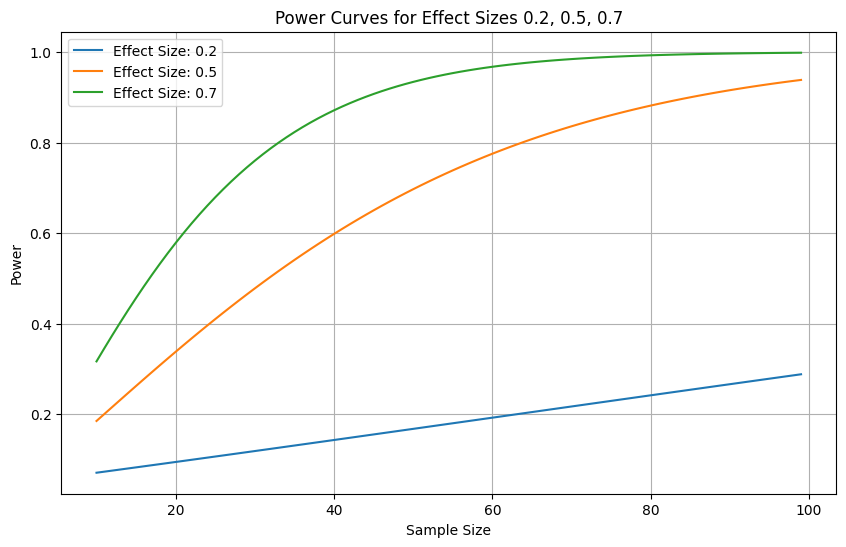

In [25]:
analysis = TTestIndPower()
effect_size = 0.7
alpha = 0.05
power = 0.91

effect_sizes = np.array([0.2, 0.5, 0.7])
sample_sizes = np.arange(10, 100, 1)


fig, ax = plt.subplots(figsize=(10, 6))

for effect in effect_sizes:
    powers = analysis.power(effect_size=effect, nobs1=sample_sizes, alpha=alpha, ratio=1.0)
    ax.plot(sample_sizes, powers, label=f"Effect Size: {effect}")

ax.set_title("Power Curves for Effect Sizes 0.2, 0.5, 0.7")
ax.set_xlabel("Sample Size")
ax.set_ylabel("Power")
ax.legend()
ax.grid(True)

plt.show()


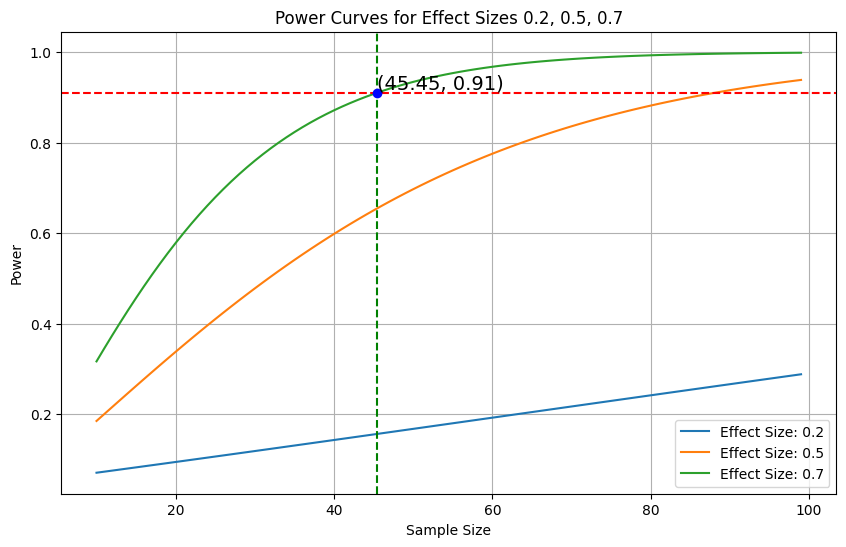

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

for effect in effect_sizes:
    powers = analysis.power(effect_size=effect, nobs1=sample_sizes, alpha=alpha, ratio=1.0)
    ax.plot(sample_sizes, powers, label=f"Effect Size: {effect}")

# Add a horizontal line for power = 0.91
ax.axhline(y=0.91, color="red", linestyle="--")

# Calculate the sample size for effect size = 0.7 and power = 0.91
# Add vertial line for power = 0.91
sample_size_for_effect_07 = analysis.solve_power(effect_size=0.7, power=0.91, alpha=alpha, ratio=1.0)
ax.axvline(x=sample_size_for_effect_07, color="green", linestyle="--")

# Plot point and display co-ordinated at intersection for power = 0.91.
ax.plot(sample_size_for_effect_07, 0.91, "bo")
coordinate_text = f"({sample_size_for_effect_07:.2f}, {0.91})"
ax.text(sample_size_for_effect_07, 0.91, coordinate_text, fontsize=14, verticalalignment="bottom")

ax.set_title("Power Curves for Effect Sizes 0.2, 0.5, 0.7")
ax.set_xlabel("Sample Size")
ax.set_ylabel("Power")
ax.legend()
ax.grid(True)

plt.show()


In [27]:
# Caluculate sample size using TTestIndPower()

sample_size = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1.0)

sample_size


45.45073088568017

In [28]:
# Let's do sample size calculation manually
# We know alpha is 0.05, we can find z-value as follows:

# Find z-score for z_alpha
alpha = 0.05
power = 0.91
effect_size = 0.7
cumm_prob_alpha = 1 - (alpha / 2)
z_alpha_2_val = stats.norm.ppf(cumm_prob_alpha)

# Find z-score for z_beta
cumm_prob_beta = 1 - power
z_beta_val = stats.norm.ppf(power)
# alternativey we could use the following:
# z_beta_val = round(abs(stats.norm.ppf(cumm_prob_beta)), 2)

sample_size_per_group = 2 * ((z_alpha_2_val + z_beta_val) / effect_size) ** 2

print("Exact sample size:", sample_size_per_group)

print("For an experiment to have statistical power = 0.91 for a two-sample t-test, with alpha = 0.05, and effect size = 0.7 we need approximately", round(sample_size_per_group),"participants in each group.")


Exact sample size: 44.46835117268164
For an experiment to have statistical power = 0.91 for a two-sample t-test, with alpha = 0.05, and effect size = 0.7 we need approximately 44 participants in each group.
